In [215]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from infodynamics.metrics import cos_sim
from src.dataset.util import read_jsonl
from sklearn.metrics.pairwise import cosine_similarity


DATA_PROCESSED = '../data/processed/'
DATA_INTERIM = '../data/interim/'

In [216]:
# for ncier printing
pd.set_option('display.max_colwidth', 20)

In [217]:
# load merged and embedded data
publications = read_jsonl(os.path.join(DATA_PROCESSED, 'publications_merged_concat.ndjson'))
df_pub = pd.DataFrame.from_dict(publications)


In [218]:
# load meta data
meta = pd.read_csv(os.path.join(DATA_INTERIM, 'meta_publications_merged.csv'))

In [219]:
# change column name to allow for merging
meta = meta.rename(columns = {'id':'pub_id'})

In [220]:
# more name changes for merging
df_pub[['pub_id', 'a_b']] = df_pub['id'].str.split('_', expand=True)

In [221]:
# merge
merged_pub = df_pub.merge(meta, on = 'pub_id')

In [222]:
merged_pub.head(20)

,id,pub_date,text,embeddings,warning,pub_id,a_b,title,date,doi,path,source,reconstructed_date
0,p1_a,,Recent studies o...,[-0.029172636568...,ok :),p1,a,"Knowing me, know...",NaN,10.1177/13623613...,data/raw/UTA pub...,parsing,2020
1,p1_b,,Introduction\nTh...,[-0.030077671632...,ok :),p1,b,"Knowing me, know...",NaN,10.1177/13623613...,data/raw/UTA pub...,parsing,2020
2,p2_a,2013-12-19,Some autistic ch...,[-0.024920951575...,ok :),p2,a,Autistic adolesc...,2013-12-19,10.1016/j.neurop...,data/raw/UTA pub...,parsing,2013-12-19
3,p2_b,2013-12-19,Introduction\nOn...,[],Error code: 400 ...,p2,b,Autistic adolesc...,2013-12-19,10.1016/j.neurop...,data/raw/UTA pub...,parsing,2013-12-19
4,p3_a,,Fast Science is ...,[-0.015155889093...,ok :),p3,a,Fast Lane to Slo...,NaN,10.1016/j.tics.2...,data/raw/UTA pub...,parsing,2019
5,p3_b,,"\nMore Speed, Mo...",[-0.024415155872...,ok :),p3,b,Fast Lane to Slo...,NaN,10.1016/j.tics.2...,data/raw/UTA pub...,parsing,2019
6,p4_a,,One contribution...,[-0.005250494461...,ok :),p4,a,NaN,NaN,10.1098/rstb.201...,data/raw/UTA pub...,parsing,2018
7,p4_b,,"\nDepression, sc...",[-0.025009071454...,ok :),p4,b,NaN,NaN,10.1098/rstb.201...,data/raw/UTA pub...,parsing,2018
8,p5_a,,,[],empty,p5,a,Mapping Mentalis...,NaN,10.1007/978-3-03...,data/raw/UTA pub...,parsing,2021
9,p5_b,,Introduction\nWe...,[],Error code: 400 ...,p5,b,Mapping Mentalis...,NaN,10.1007/978-3-03...,data/raw/UTA pub...,parsing,2021


In [223]:
# truncating warnings to allow for countng
merged_pub['warning'] = merged_pub['warning'].str[:15]

In [224]:
# count warnings
merged_pub.warning.value_counts()

warning
ok :)              312
empty              155
Error code: 400     81
Name: count, dtype: int64

In [225]:
# get only the embeddings that worked
df = merged_pub.loc[df_pub['warning'] == "ok :)"]

In [226]:
# count number of abstract and bodies
df.a_b.value_counts()

a_b
b    193
a    119
Name: count, dtype: int64

In [227]:
df.shape

(312, 13)

In [228]:
# manually removing abstracts that are not abstracts 
df_clean = df[~df.text.str.startswith("This article")]
df_clean = df_clean[~df_clean.text.str.startswith("Role of land-surface")]
df_clean = df_clean[~df_clean.text.str.startswith("16 . The NIK gene")]
df_clean = df_clean[~df_clean.text.str.startswith("(1225 articles)")]




In [229]:
df_clean.shape

(303, 13)

In [230]:
df_clean = df_clean.sort_values(by = 'reconstructed_date')

In [231]:
# getting cosine similarity between each abstract and article body
distances = {}
missing_ids = []

# looping over all id's
for id in df_clean['pub_id'].unique():
    try:
        # if both an abstract and body exist for that ID, calculate distance and add to dict
        abs = df_clean[df_clean['id'] == str(id) + "_a"]
        bod = df_clean[df_clean['id'] == str(id) + "_b"]
        dist = cos_sim(np.array(abs['embeddings'].values.tolist()), np.array(bod['embeddings'].values.tolist()))
        distances[id] = dist[0][0]
    except ValueError:
        # if either abstract or body is missing for that id, appending id to missing_ids list
        missing_ids.append(id)

    
        

In [232]:
# checking for low cosine sims – a sign of an abstract not being an abstract
lows = [k for k, v in distances.items() if v < 0.80]

lows

[]

In [233]:
# seeing which texts are low
for pub in lows:
    print(publications.loc[publications['id'] == pub+'_a', ['text']] )


In [234]:
len(missing_ids)

145

In [235]:
len(distances)


79

In [236]:
# making the distnaces dict into a df
ab_bod_df = pd.DataFrame.from_dict(distances, orient='Index', columns=['cos_sim'])

In [237]:
ab_bod_df.columns

Index(['cos_sim'], dtype='object')

In [238]:
ab_bod_df = ab_bod_df.reset_index().rename(columns={'index': 'pub_id'})

In [239]:
ab_bod_df = ab_bod_df.merge(meta, on = 'pub_id')

In [240]:
ab_bod_df

,pub_id,cos_sim,title,date,doi,path,source,reconstructed_date
0,p74,0.883444,STUDIES IN PATTE...,NaN,NaN,data/raw/UTA pub...,parsing,1970
1,p92,0.936929,Other minds in t...,NaN,NaN,data/raw/UTA pub...,parsing,1995
2,p29,0.947132,Specific cogniti...,NaN,NaN,data/raw/UTA pub...,parsing,1998
3,p32,0.956959,Identifying Dysl...,NaN,NaN,data/raw/UTA pub...,parsing,1998
4,p28,0.880196,What autism teac...,NaN,NaN,data/raw/UTA pub...,parsing,1998
...,...,...,...,...,...,...,...,...
74,p3,0.904754,Fast Lane to Slo...,NaN,10.1016/j.tics.2...,data/raw/UTA pub...,parsing,2019
75,p10,0.898964,Developmental Co...,2019-06-01,10.1016/j.dcn.20...,data/raw/UTA pub...,parsing,2019-06-01
76,p1,0.935279,"Knowing me, know...",NaN,10.1177/13623613...,data/raw/UTA pub...,parsing,2020
77,p120,0.900449,Teaching in 2020...,NaN,10.1080/02607470...,data/raw/UTA pub...,parsing,2020


In [241]:
def generate_xticks(df):
    # flag indices, where the next element is different
    yr_switches = np.diff(df["year"])
    # add last element
    yr_switches = np.append(0, yr_switches)
    # convert to bool
    yr_switches = np.array(yr_switches, dtype=bool)

    # get index (x-axis) and year variables (x-axis label)
    sig_index = np.array(df.index)
    sig_year = np.array(df["year"])

    # mark changes in year
    xticks_idx = sig_index[yr_switches]
    xticks_label = sig_year[yr_switches]

    return xticks_idx, xticks_label



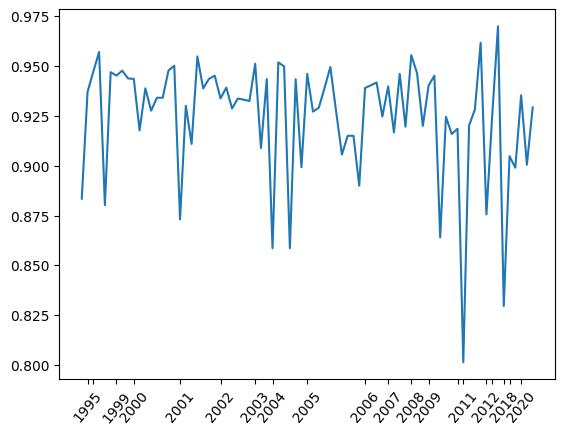

In [242]:
# plotting over the years 

# extract just the year
ab_bod_df['year'] = [funk.year for funk in pd.to_datetime(ab_bod_df['reconstructed_date'], format='mixed')]
# flag indices, where the next element is different (those are the tick labels you want to show on the x axis)
xticks_idx, xticks_label = generate_xticks(ab_bod_df.reset_index())


# creating
x = range(len(ab_bod_df))
y1 = list(ab_bod_df['cos_sim'])

plt.plot(x, y1, label ='y1')

# modifying xticks
values_to_hide = [1998,2010,2013,2019]
modified_labels = ['' if i in values_to_hide else i for i in xticks_label]

# set xticks
plt.xticks(ticks=xticks_idx, labels=modified_labels, rotation = 50)
# saving
plt.savefig('abstracts_exp.png')
# showing
plt.show()


## Pairwise cosine sim for abstracts and bodies

In [243]:
abs = df_clean.loc[df_clean['id'].str.endswith('_a')]
bods = df_clean.loc[df_clean['id'].str.endswith('_b')]

In [244]:
abs.shape

(110, 13)

In [245]:
bods.shape

(193, 13)

In [246]:
abs_cos_sim = cosine_similarity([np.array(embed) for embed in abs['embeddings']])

bods_cos_sim = cosine_similarity([np.array(embed) for embed in bods['embeddings']])

full_cos_sim = cosine_similarity([np.array(embed) for embed in bods['embeddings']], [np.array(embed) for embed in abs['embeddings']])

In [247]:
descriptive_stats = {}

arrays = {'abs':abs_cos_sim, 'bods':bods_cos_sim, 'full':full_cos_sim, 'abs_bods': np.array(ab_bod_df['cos_sim'])}

for array, values in arrays.items():
    temp = {
        'range': np.ptp(values),
        'mean': np.mean(values),
        'std': np.std(values),
        'max': np.max(values),
        'min': np.min(values),
        'quantile_25': np.quantile(values, 0.25),
        'quantile_50': np.quantile(values, 0.50),
        'quantile_75': np.quantile(values, 0.75),
    }

    descriptive_stats[array] = temp

descriptive_stats


{'abs': {'range': 0.31608431140581783,
  'mean': 0.8164844640182888,
  'std': 0.04530060000175215,
  'max': 1.0000000000000013,
  'min': 0.6839156885941835,
  'quantile_25': 0.787867129795495,
  'quantile_50': 0.8140322471787886,
  'quantile_75': 0.8431261236558691},
 'bods': {'range': 0.34300445045560124,
  'mean': 0.8317992116644277,
  'std': 0.042910495012587306,
  'max': 1.0000000000000024,
  'min': 0.6569955495444012,
  'quantile_25': 0.8042089974008602,
  'quantile_50': 0.8307622121093561,
  'quantile_75': 0.8589608072816215},
 'full': {'range': 0.3244857651450467,
  'mean': 0.8069094790792873,
  'std': 0.04132735861592324,
  'max': 0.9698363475499375,
  'min': 0.6453505824048908,
  'quantile_25': 0.7791294098335044,
  'quantile_50': 0.8050892373558376,
  'quantile_75': 0.8334282022437997},
 'abs_bods': {'range': 0.16838219167061386,
  'mean': 0.9248331749403953,
  'std': 0.02956829035420896,
  'max': 0.9698363475499373,
  'min': 0.8014541558793234,
  'quantile_25': 0.91624552128